## Texas Open Data Portal API Request

In this project, I'll be finding the topics in the Dallas City Council's agenda item descriptions. 

The agenda item descriptions are a part of the Dallas City Council Voting Record datast. To get the dataset, you can either download it from the portal, or using the Socrata API.

In [1]:
import pandas as pd
from sodapy import Socrata

# Example authenticated client (needed for non-public datasets):
client = Socrata("www.dallasopendata.com",
                  'APP KEY',
                  username="mwtichenor@gmail.com",
                  password="PASSWORD")

results = client.get("ts5d-gdq6", limit=9999999)

client.close()

In [2]:
results_df = pd.DataFrame.from_records(results)
results_df.head()

,date,agenda_item_number,item_type,district,title,voter_name,vote,final_action_taken,agenda_item_description,agenda_id,vote_id
0,2020-04-01T00:00:00.000,1,AGENDA,7,Councilmember,Adam Bazaldua,YES,APPROVED,"Approval of Minutes of the March 4, 2020 City ...",040120_AG_1,040120_AG_1_7
1,2020-04-01T00:00:00.000,2,AGENDA,1,Councilmember,Chad West,YES,APPROVED,Consideration of appointments to boards and co...,040120_AG_2,040120_AG_2_1
2,2020-04-01T00:00:00.000,1,AGENDA,6,Councilmember,Omar Narvaez,YES,APPROVED,"Approval of Minutes of the March 4, 2020 City ...",040120_AG_1,040120_AG_1_6
3,2020-04-01T00:00:00.000,2,AGENDA,10,Deputy Mayor Pro Tem,B. Adam McGough,YES,APPROVED,Consideration of appointments to boards and co...,040120_AG_2,040120_AG_2_10
4,2020-04-01T00:00:00.000,1,AGENDA,9,Councilmember,Paula Blackmon,YES,APPROVED,"Approval of Minutes of the March 4, 2020 City ...",040120_AG_1,040120_AG_1_9


What's the time period for these agenda items?

In [3]:
results_df["date"].value_counts().sort_index()

2016-09-07T00:00:00.000      75
2016-09-14T00:00:00.000    1575
2016-09-21T00:00:00.000     135
2016-09-28T00:00:00.000    1065
2016-10-11T00:00:00.000     735
                           ... 
2020-02-26T00:00:00.000    1230
2020-03-04T00:00:00.000      30
2020-03-18T00:00:00.000      30
2020-03-25T00:00:00.000    1005
2020-04-01T00:00:00.000      30
Name: date, Length: 132, dtype: int64

How many agenda items are there?

In [4]:
results_df["agenda_id"].nunique()

4876

In [5]:
results_df = results_df.loc[:, ["agenda_id", "agenda_item_description"]].drop_duplicates()

Checkout a sample agenda.

In [6]:
results_df.iloc[369,1]

'Authorize a contract with Dallas Area Rapid Transit for the purchase of 300 annual passes in support of the City?s clean air initiative - Not to exceed $60,000.00 - Financing: General Fund (see Fiscal Information)'

## Data Preprocessing

The first and probably most important task in this process, is tokenizing the agenda item descriptions. Tokenization is the process of splitting a text into tokens.

Processing the data, I'll be removing punctuation, removing numbers, removing stopwords, then lemmatizing each word of the text, before splitting it into a list of one word tokens.

In [7]:
agendas = results_df.iloc[:, 1].tolist()

In [8]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_short
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_numeric, remove_stopwords
import spacy

nlp = spacy.load("en_core_web_sm")

As an example, here's one agenda item description.

In [9]:
txt = agendas[311]
print(txt)

Authorize a professional services contract with The Kercher Group, Inc. to provide Pavement Management Consultant Services including pavement modeling evaluation, evaluation and review of current practices, quality management review of pavement condition data collection, and review of sidewalk and alley management practices - Not to exceed $232,431.58 - Financing: General Fund


After removing punctuation, it looks like this:

In [10]:
txt = strip_punctuation(txt)
print(txt)

Authorize a professional services contract with The Kercher Group  Inc  to provide Pavement Management Consultant Services including pavement modeling evaluation  evaluation and review of current practices  quality management review of pavement condition data collection  and review of sidewalk and alley management practices   Not to exceed  232 431 58   Financing  General Fund


After removing numbers, it looks like this:

In [11]:
txt = strip_numeric(txt)
print(txt)

Authorize a professional services contract with The Kercher Group  Inc  to provide Pavement Management Consultant Services including pavement modeling evaluation  evaluation and review of current practices  quality management review of pavement condition data collection  and review of sidewalk and alley management practices   Not to exceed       Financing  General Fund


After removing stopwords, it looks like this:

In [12]:
txt = remove_stopwords(txt)
print(txt)

Authorize professional services contract The Kercher Group Inc provide Pavement Management Consultant Services including pavement modeling evaluation evaluation review current practices quality management review pavement condition data collection review sidewalk alley management practices Not exceed Financing General Fund


Then after lemmatization, it looks like this:

In [13]:
doc = nlp(txt)
lemmatized = []
for token in doc:
    lemmatized.append(token.lemma_)

print(' '.join(lemmatized))

authorize professional service contract the Kercher Group Inc provide Pavement Management Consultant Services include pavement modeling evaluation evaluation review current practice quality management review pavement condition data collection review sidewalk alley management practice not exceed Financing General Fund


I'll apply repeat this process for every agenda item description in the dataset...

In [14]:
def spacy_lemmatize(x):
    doc = nlp(x)
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)

CUSTOM_FILTERS = [lambda x: x.replace('�',"'"), strip_punctuation,
                  strip_numeric, remove_stopwords, spacy_lemmatize]

texts = [preprocess_string(agenda, CUSTOM_FILTERS) for agenda in agendas]

create a dictionary for the agenda item descriptions...

In [15]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)

print(dictionary)

Dictionary(8879 unique tokens: ['Briefing', 'City', 'Council', 'March', 'Meeting']...)


then using the dictionary transform each agenda item description to a bag-of-words.

Here's what the bag-of-words looks like.

In [16]:
corpus = [dictionary.doc2bow(text) for text in texts]

print(corpus[311])

[(17, 2), (31, 1), (33, 1), (34, 1), (36, 1), (40, 1), (48, 1), (58, 1), (105, 1), (107, 1), (120, 1), (185, 2), (202, 1), (267, 1), (296, 1), (298, 1), (456, 1), (484, 1), (633, 1), (918, 1), (974, 1), (1130, 3), (1342, 1), (1521, 1), (2158, 1), (2159, 1), (2160, 1), (2161, 1), (2162, 1), (2163, 2), (2164, 2), (2165, 1)]


It's a list of tuples, where the first item in the tuple refers to a word in the dictionary, and the second item is the frequency count.

For example, here's the bag-of-words for that same agenda item description I showed earlier.

In [17]:
for id, freq in corpus[311]:
    print((dictionary[id], freq))


('evaluation', 2)
('Financing', 1)
('Fund', 1)
('General', 1)
('Management', 1)
('Services', 1)
('authorize', 1)
('service', 1)
('exceed', 1)
('not', 1)
('Inc', 1)
('management', 2)
('provide', 1)
('condition', 1)
('contract', 1)
('professional', 1)
('Group', 1)
('include', 1)
('sidewalk', 1)
('data', 1)
('current', 1)
('review', 3)
('the', 1)
('alley', 1)
('Consultant', 1)
('Kercher', 1)
('Pavement', 1)
('collection', 1)
('modeling', 1)
('pavement', 2)
('practice', 2)
('quality', 1)


For some models, a [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term frequency-inverse document frequency) transformation can improve performance. 

Now, I'll apply the TF-IDF transformation to each bag-of-words in the corpus.

Here's the TF-IDF transformation of that document.

In [18]:
from gensim import models

tfidf = models.TfidfModel(corpus) 

corpus_tfidf = tfidf[corpus]

for id, freq in corpus_tfidf[311]:
    print((dictionary[id], freq))

('evaluation', 0.21188832614014183)
('Financing', 0.016646802680202903)
('Fund', 0.044295053902416365)
('General', 0.06491710719280125)
('Management', 0.09270150688005326)
('Services', 0.0750655765830837)
('authorize', 0.01725923117908318)
('service', 0.040430470045679914)
('exceed', 0.025757074065474835)
('not', 0.03128513839202381)
('Inc', 0.04836718575109044)
('management', 0.21145001794595045)
('provide', 0.05687813663445035)
('condition', 0.11019607756260195)
('contract', 0.04174615032119411)
('professional', 0.07893549473859429)
('Group', 0.09565157593957953)
('include', 0.0947351469883799)
('sidewalk', 0.14309151313956292)
('data', 0.17963275363657077)
('current', 0.09927890634302312)
('review', 0.4594948385188758)
('the', 0.1055074722640264)
('alley', 0.12962806123343126)
('Consultant', 0.250313331169163)
('Kercher', 0.250313331169163)
('Pavement', 0.1855477411716934)
('collection', 0.108230276587271)
('modeling', 0.250313331169163)
('pavement', 0.34941730471224186)
('practice'

## Model Training and Evaluation

The number of topics is a hyper-parameter for the topic models. In a loop, I train a LSI (Latent Semantic Indexing) topic model using a number of topics, then evaluate the performance using the C_V coherence measure.

The C_V coherence measure, measures the quality of the topic modeling; and it has had the highest correlation with domain experts.

In [19]:
from gensim.models.coherencemodel import CoherenceModel

topics = list(range(1, 21))
scores = []

for t in topics:
    lsi = models.LsiModel(corpus_tfidf, num_topics = t, id2word=dictionary)
    #corpus_lsi = lsi[corpus_tfidf]
    lsitopics = lsi.show_topics(formatted=False)
    lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]
    cm = CoherenceModel(topics = lsitopics, 
                    texts = texts,
                    dictionary=dictionary)
    score = cm.get_coherence()
    scores.append(score)
    print("Num Topics: ", t, "; C_V: ", score)

Num Topics:  1 ; C_V:  0.9423819545540073
Num Topics:  2 ; C_V:  0.9692570526074304
Num Topics:  3 ; C_V:  0.9319444923447361
Num Topics:  4 ; C_V:  0.8574558178602345
Num Topics:  5 ; C_V:  0.8439460170873525
Num Topics:  6 ; C_V:  0.8168833047381282
Num Topics:  7 ; C_V:  0.7524731931706611
Num Topics:  8 ; C_V:  0.706254333584823
Num Topics:  9 ; C_V:  0.7243204673958691
Num Topics:  10 ; C_V:  0.7471840691532788
Num Topics:  11 ; C_V:  0.692881189722807
Num Topics:  12 ; C_V:  0.6922062883262469
Num Topics:  13 ; C_V:  0.6596754020784693
Num Topics:  14 ; C_V:  0.6400462228576865
Num Topics:  15 ; C_V:  0.6275913723576626
Num Topics:  16 ; C_V:  0.6398762853689836
Num Topics:  17 ; C_V:  0.6237495300581343
Num Topics:  18 ; C_V:  0.6045916619402096
Num Topics:  19 ; C_V:  0.6099948819887815
Num Topics:  20 ; C_V:  0.6155484499964552


Repeat this for the NMF (Non-Negative Matrix Factorization) topic model.

In [20]:
from gensim.models.nmf import Nmf

nmf_scores = []

for t in topics:
    nmf = Nmf(corpus_tfidf, num_topics = t, id2word=dictionary, random_state = 13)
    #corpus_lsi = lsi[corpus_tfidf]
    nmftopics = nmf.show_topics(formatted=False)
    nmftopics = [[word for word, prob in topic] for topicid, topic in nmftopics]
    cm = CoherenceModel(topics = nmftopics, 
                    texts = texts,
                    dictionary=dictionary)
    nmf_score = cm.get_coherence()
    nmf_scores.append(nmf_score)
    print("Num Topics: ", t, "; C_V: ", nmf_score)

Num Topics:  1 ; C_V:  0.6996830388125176
Num Topics:  2 ; C_V:  0.8892586925618635
Num Topics:  3 ; C_V:  0.6581959997575711
Num Topics:  4 ; C_V:  0.6823594822945948
Num Topics:  5 ; C_V:  0.8116965801849447
Num Topics:  6 ; C_V:  0.5170436007219237
Num Topics:  7 ; C_V:  0.6595474862507668
Num Topics:  8 ; C_V:  0.6876437787899712
Num Topics:  9 ; C_V:  0.8149177040636931
Num Topics:  10 ; C_V:  0.8134370996697593
Num Topics:  11 ; C_V:  0.7484645112502315
Num Topics:  12 ; C_V:  0.7183086990849488
Num Topics:  13 ; C_V:  0.8324351626570305
Num Topics:  14 ; C_V:  0.7900520808117295
Num Topics:  15 ; C_V:  0.7670308363206224
Num Topics:  16 ; C_V:  0.6674429562416591
Num Topics:  17 ; C_V:  0.7375366189938563
Num Topics:  18 ; C_V:  0.6634263882166842
Num Topics:  19 ; C_V:  0.7501699902981339
Num Topics:  20 ; C_V:  0.769014693921935


Repeat for the LDA (latent dirichlet allocation) model.

In [21]:
from gensim.models.ldamodel import LdaModel

lda_scores = []

for t in topics:
    lda = LdaModel(corpus, num_topics = t, id2word=dictionary, random_state = 13)
    #corpus_lsi = lsi[corpus_tfidf]
    ldatopics = lda.show_topics(formatted=False)
    ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]
    cm = CoherenceModel(topics = ldatopics, 
                    texts = texts,
                    dictionary=dictionary)
    lda_score = cm.get_coherence()
    lda_scores.append(lda_score)
    print("Num Topics: ", t, "; C_V: ", lda_score)

Num Topics:  1 ; C_V:  0.4042799605610073
Num Topics:  2 ; C_V:  0.7560824127942687
Num Topics:  3 ; C_V:  0.7518613405828255
Num Topics:  4 ; C_V:  0.669377564247603
Num Topics:  5 ; C_V:  0.5980828328210164
Num Topics:  6 ; C_V:  0.6642414208074904
Num Topics:  7 ; C_V:  0.7326193718844076
Num Topics:  8 ; C_V:  0.7049719693535652
Num Topics:  9 ; C_V:  0.6794860978009716
Num Topics:  10 ; C_V:  0.7297011696080853
Num Topics:  11 ; C_V:  0.7138656594412727
Num Topics:  12 ; C_V:  0.6898322028609429
Num Topics:  13 ; C_V:  0.7199955193634396
Num Topics:  14 ; C_V:  0.7488066727414924
Num Topics:  15 ; C_V:  0.7207604604858799
Num Topics:  16 ; C_V:  0.6933964862763665
Num Topics:  17 ; C_V:  0.7267984114079085
Num Topics:  18 ; C_V:  0.7306731508304599
Num Topics:  19 ; C_V:  0.7684368515417641
Num Topics:  20 ; C_V:  0.7710192181628245


Plot the performance.

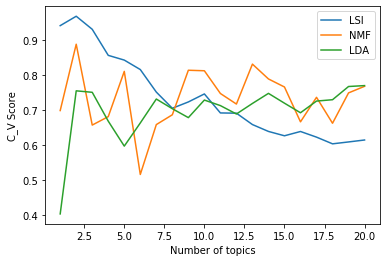

In [22]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.plot(topics, scores, label = "LSI")
plt.plot(topics, nmf_scores, label = "NMF")
plt.plot(topics, lda_scores, label = "LDA")
plt.ylabel("C_V Score")
plt.xlabel("Number of topics")
plt.legend()
plt.show()

LSI outperformed the other models with a C_V score of 0.97!

## Analyzing Results

Looking at the 2 topics in the LSI model.

In [27]:
NUM = 2

lsi = models.LsiModel(corpus_tfidf, num_topics = NUM, id2word=dictionary)
corpus_lsi = lsi[corpus_tfidf]
lsi.show_topics()

[(0,
  '0.333*"District" + 0.169*"public" + 0.166*"hearing" + 0.165*"property" + 0.162*"ordinance" + 0.157*"application" + 0.156*"comment" + 0.155*"a" + 0.154*"zone" + 0.152*"receive"'),
 (1,
  '0.475*"commission" + 0.469*"board" + 0.241*"duties" + 0.239*"appointment" + 0.236*"evaluation" + 0.236*"nominee" + 0.231*"available" + 0.230*"member" + 0.221*"Secretary" + 0.206*"list"')]

The first topic seems to be about property, while the second topic seems to be about political appointees.

Now, there are two topics, but that doesn't mean there are only two types of agenda items. Instead each agenda item description is a mixture of these two topics.

Let's plot the distribution of topic weights in the corpus.

In [28]:
import numpy as np
from gensim.matutils import corpus2dense

coprus_lsi_mat = corpus2dense(corpus_lsi, 2)

In [29]:
coprus_lsi_mat.shape

(2, 4876)

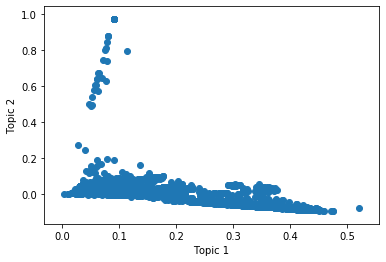

In [30]:
plt.scatter(coprus_lsi_mat[0, :], coprus_lsi_mat[1, :]) 
plt.xlabel("Topic 1")
plt.ylabel("Topic 2")
plt.show()

Here's the document with the highest weight for the first topic.

In [31]:
np.argmax(coprus_lsi_mat[0, :])

3622

In [32]:
agendas[3622]

'A public hearing to receive comments regarding an application for and (1) an ordinance granting a TH-2(A) Townhouse District on property zoned Planned Development District No. 624 and an R-7.5(A) Single Family District; (2) an ordinance granting an MF-2(A) Multifamily District on property zoned Planned Development District No. 624; (3) an ordinance granting a CR Community Retail District on property zoned Planned Development District No. 624 and an R-7.5(A) Single Family District; (4) an ordinance granting an MF-3(A) Multifamily District on property zoned Planned Development District No. 624, an R-7.5(A) Single Family District, and a CR Community Retail District; (5) an ordinance granting a CR Community Retail District on property zoned an NS(A) Neighborhood Service District; (6) an ordinance granting an MF-3(A) Multifamily District on property zoned an R-7.5(A) Single Family District; (7) an ordinance granting an MF-2(A) Multifamily District on property zoned an R-7.5(A) Single Famil

Here's the document with the highest weight for the second topic.

In [33]:
np.argmax(coprus_lsi_mat[1, :])

1

In [34]:
agendas[1]

"Consideration of appointments to boards and commissions and the evaluation and duties of board and commission members (List of nominees is available in the City Secretary's Office)"

## Conclusion

Wrapping this up, I pulled Dallas City Council agenda item descriptions using the Socrata API, preprocessed text, tested several topic models, then interpretted the two topics found in the corpus. 

This project can be used as a blue print for other Topic Modeling projects. In addition, the switch from the document-term space to the document-topic space compresses a lot of information, and can make document clustering or similarity based queries much faster. I may try either of these techniques in a follow-up.

Like always, thanks for reading.